In [ ]:
# NOTE:

# Because there are 3 classes, the AUC is calculated as the average of the AUCs of the individual classes.

# The given train set is divided in a 90:10 ratio into "train" and "validation" sets. This "validation" set is used for hyperparameter tuning.
# The given val set is considered as the external train set.
# Thus, there are 3 sets in total.

In [ ]:
!unzip './data' -d './data/'

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plot

import os
import random

In [ ]:
# Set random seed
SEED = 0
keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

In [ ]:
BASEPATH = './data/dataset' # Location of data
MODELPATH = './weights' # Location of weights
BATCH_SIZE = 256
EPOCHS = 300
LEARNING_RATE = 5e-4

In [ ]:
def load_data(datatype):
  x, y = [], []
  for index, category in enumerate(['no', 'sphere', 'vort']): # Labels: no=0, sphere=1, vort=2
    category_path = os.path.join(BASEPATH, datatype, category)
    for filename in os.listdir(category_path):
      filedata = np.load(os.path.join(category_path, filename))
      x.append(filedata)
      label = np.stack([np.eye(3)[index] for _ in range(len(filedata))], axis=0) # make one-hot encoding
      y.append(label)
  x = np.expand_dims(np.concatenate(x, axis=0), axis=-1) # add channel axis
  y = np.concatenate(y, axis=0)

  # Save
  np.save(os.path.join(BASEPATH, f'X_{datatype}.npy'), x)
  np.save(os.path.join(BASEPATH, f'Y_{datatype}.npy'), y)

  return x, y

In [ ]:
# Load data
X_TRAIN, Y_TRAIN = load_data('train')
X_VAL, Y_VAL = load_data('val')

# Standardize data
X_TRAIN = ((X_TRAIN - np.mean(X_TRAIN, axis=(1, 2), keepdims=True))
          / np.std(X_TRAIN, axis=(1, 2), keepdims=True))
X_VAL = ((X_VAL - np.mean(X_VAL, axis=(1, 2), keepdims=True))
          / np.std(X_VAL, axis=(1, 2), keepdims=True))

# Shuffle data
perm = np.random.permutation(len(X_TRAIN))
X_TRAIN, Y_TRAIN = X_TRAIN[perm], Y_TRAIN[perm]
perm = np.random.permutation(len(X_VAL))
X_VAL, Y_VAL = X_VAL[perm], Y_VAL[perm]

In [ ]:
def make_model(input_shape):
  inputs = keras.Input(shape=input_shape)
  x = keras.Sequential([
                        layers.RandomFlip(),
                        layers.RandomRotation(0.5)
                        ])(inputs)
  
  x = layers.Conv2D(16, 5)(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  for _ in range(3):
    x = layers.Conv2D(32, 3)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
  
  for _ in range(2):
    residual = layers.Conv2D(64, 1)(x)
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.add([x, residual])


  x = layers.Conv2D(128, 3)(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.Flatten()(x)

  x = layers.Dense(256, activation='relu')(x)
  x = layers.Dense(32, activation='relu')(x)
  outputs = layers.Dense(3, activation='softmax')(x)

  return keras.Model(inputs, outputs)

In [ ]:
class TrackBestPerformance(keras.callbacks.Callback):
  """
  Callback to keep track of model weights which give best val_auc
  After training completes, the model is assigned with the best model weights
  """
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.best_auc = 0
    self.best_epoch = -1
    self.best_weights = None
  
  def on_epoch_end(self, epoch, logs=None):
    current_auc = logs['val_auc']
    if current_auc > self.best_auc:
      self.best_auc = current_auc
      self.best_epoch = epoch
      self.best_weights = self.model.get_weights()
  
  def on_train_end(self, logs=None):
    self.model.set_weights(self.best_weights)
    print(f'Best validation AUC is {self.best_auc} on epoch #{self.best_epoch + 1}')


In [ ]:
model = make_model(X_TRAIN.shape[1:])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=keras.metrics.AUC(multi_label=True, num_labels=3, name='auc'))

history = model.fit(X_TRAIN, Y_TRAIN, validation_split=0.1,
                    batch_size=BATCH_SIZE, epochs=EPOCHS,
                    callbacks=[TrackBestPerformance()])

Epoch 1/300
106/106 [==============================] - 53s 381ms/step - loss: 1.4276 - auc: 0.5076 - val_loss: 1.1014 - val_auc: 0.5092
Epoch 2/300
106/106 [==============================] - 38s 361ms/step - loss: 1.1383 - auc: 0.5133 - val_loss: 1.1180 - val_auc: 0.5153
Epoch 3/300
106/106 [==============================] - 38s 355ms/step - loss: 1.1321 - auc: 0.5153 - val_loss: 1.1011 - val_auc: 0.5321
Epoch 4/300
106/106 [==============================] - 38s 359ms/step - loss: 1.1145 - auc: 0.5256 - val_loss: 1.0968 - val_auc: 0.5531
Epoch 5/300
106/106 [==============================] - 38s 357ms/step - loss: 1.0764 - auc: 0.5854 - val_loss: 1.2081 - val_auc: 0.6512
Epoch 6/300
106/106 [==============================] - 38s 357ms/step - loss: 0.9932 - auc: 0.6764 - val_loss: 0.9998 - val_auc: 0.6853
Epoch 7/300
106/106 [==============================] - 38s 357ms/step - loss: 0.9176 - auc: 0.7321 - val_loss: 1.2216 - val_auc: 0.7199
Epoch 8/300
106/106 [===========================

In [ ]:
print('Best validation AUC: {}'.format(max(history.history['val_auc'])))
print('Corresponding train AUC: {}'.format(history.history['auc'][np.argmax(history.history['val_auc'])]))

Best validation AUC: 0.9932315945625305
Corresponding train AUC: 0.9966993927955627


In [ ]:
# Evaluate on test data
val_auc = model.evaluate(X_VAL, Y_VAL)[1]
print(f'AUC on test data: {val_auc}')

235/235 [==============================] - 3s 12ms/step - loss: 0.1380 - auc: 0.9924
AUC on test data: 0.9924206733703613


In [ ]:
X_BATCHES_TRAIN = np.array_split(X_TRAIN, 50, axis=0)
Y_PRED_TRAIN = np.concatenate([model(x_batch).numpy() for x_batch in X_BATCHES_TRAIN], axis=0)

X_BATCHES_VAL = np.array_split(X_VAL, 50, axis=0)
Y_PRED_VAL = np.concatenate([model(x_batch).numpy() for x_batch in X_BATCHES_VAL], axis=0)

In [ ]:
def compute_roc_points(y, y_pred, num_thresholds=200):
  thresholds = np.linspace(0., 1., num_thresholds)

  tp, fp, tn, fn = [], [], [], []

  for threshold in thresholds:
    y_pred_label = (y_pred > threshold).astype(int)
    tp.append(np.count_nonzero(((y_pred_label == 1) & (y == 1)), axis=0))
    fp.append(np.count_nonzero(((y_pred_label == 1) & (y == 0)), axis=0))
    tn.append(np.count_nonzero(((y_pred_label == 0) & (y == 0)), axis=0))
    fn.append(np.count_nonzero(((y_pred_label == 0) & (y == 1)), axis=0))

  tp, fp, tn, fn = np.array(tp), np.array(fp), np.array(tn), np.array(fn)

  tp_rate = tp / (tp + fn)
  fp_rate = fp / (fp + tn)

  return fp_rate, tp_rate

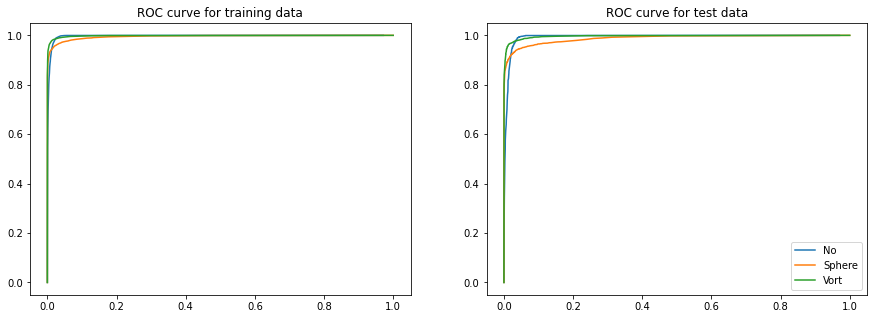

In [19]:
fig, axes = plot.subplots(nrows=1, ncols=2, figsize=(15, 5))

fp_rate_train, tp_rate_train = compute_roc_points(Y_TRAIN, Y_PRED_TRAIN)
_ = axes[0].plot(fp_rate_train[:, 0], tp_rate_train[:, 0], label='No')
_ = axes[0].plot(fp_rate_train[:, 1], tp_rate_train[:, 1], label='Sphere')
_ = axes[0].plot(fp_rate_train[:, 2], tp_rate_train[:, 2], label='Vort')
_ = axes[0].set(title='ROC curve for training data')

fp_rate_val, tp_rate_val = compute_roc_points(Y_VAL, Y_PRED_VAL)
_ = axes[1].plot(fp_rate_val[:, 0], tp_rate_val[:, 0], label='No')
_ = axes[1].plot(fp_rate_val[:, 1], tp_rate_val[:, 1], label='Sphere')
_ = axes[1].plot(fp_rate_val[:, 2], tp_rate_val[:, 2], label='Vort')
_ = axes[1].set(title='ROC curve for test data')

_ = plot.legend()

In [ ]:
# Save model weights
model.save(MODELPATH)

INFO:tensorflow:Assets written to: /content/weights/assets


In [ ]:
# Compress model weights
!zip -r './test_1_weights.zip' './weights'

In [ ]:
# Load model weights
model = keras.models.load_model(MODELPATH)

In [ ]:
# Run this cell to evaluate on test data
X_TEST, Y_TEST = None, None # load test data here. Shape: (None, 150, 150, 1)

# Standardize test data
X_TEST = ((X_TEST - np.mean(X_TEST, axis=(1, 2), keepdims=True))
          / np.std(X_TEST, axis=(1, 2), keepdims=True))

model.evaluate(X_TEST, Y_TEST)